In [1]:
import os
import cv2
import glob
import json
import torch
import tifffile
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from satlasswin import SatlasSwin
from torch.utils.data import Dataset, DataLoader, random_split
from classification_datasets import ClassificationDataset, ClassificationTrainDataset ,ClassificationValDataset

# DataSet Fixing

In [4]:
cdata = ClassificationDataset(
    root_dir="..\\ICPR02\\kaggle",
    mask_type='random',
    augment=True,
    target_size=(256, 256)
)

train_dataset = ClassificationTrainDataset(cdata,80,20,42,augment=False)
val_dataset = ClassificationValDataset(cdata,20,42)
print(len(train_dataset), len(val_dataset))
class SelectiveDataset(Dataset):
    def __init__(self, backing_dataset, labels):
        self.backing_dataset = backing_dataset
        self.samples_by_class = {label: samples for label, samples in backing_dataset.samples_by_class.items() if label in labels}
        self.samples = []
        for _, class_samples in self.samples_by_class.items():
            self.samples.extend(class_samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        c9 = img[(3,2,1,4,5,6,7,10,11),:,:]
        c12 = img[(3,2,1,4,5,6,7,10,11,0,8,9),:,:]
        return {
            'c9': c9,
            'c12': c12,
            'label': label
        }
    
    def __len__(self):
        return len(self.samples)
    
# DataSet Fixing
class SelectiveDataset(Dataset):
    def __init__(self, backing_dataset, labels):
        self.backing_dataset = backing_dataset
        self.samples_by_class = {label: samples for label, samples in backing_dataset.samples_by_class.items() if label in labels}
        self.samples = []
        for _, class_samples in self.samples_by_class.items():
            self.samples.extend(class_samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        c9 = img[(3,2,1,4,5,6,7,10,11),:,:]
        c12 = img[(3,2,1,4,5,6,7,10,11,0,8,9),:,:]
        return {
            'c9': c9,
            'c12': c12,
            'label': label
        }
    
    def __len__(self):
        return len(self.samples)

Loading dataset into memory...


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:27<00:00, 41.42s/it]

Found 900 samples with all 12 bands
235 80


In [5]:
train_dataset = SelectiveDataset(train_dataset, ['RPH','Blast','Rust', 'Aphid'])
val_dataset = SelectiveDataset(val_dataset,['RPH','Blast','Rust', 'Aphid'])

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


DataLoaders created successfully!
Train batches: 15
Val batches: 5


# Feature Extractor

In [2]:
class FeatureExtractor(nn.Module):
    def __init__(self,channels = 9,reducer = "GAP",*args, **kwargs):
        super().__init__(*args, **kwargs)

        self.reducer = reducer
        self.encoder = SatlasSwin(channels=channels)
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.encoder.eval()

        self.deep_reducer = nn.Sequential(
            nn.Conv2d(1024,128,kernel_size=1,stride=1),
                        nn.LeakyReLU(),
                        nn.Flatten(),
                        nn.Linear(128 * 8 * 8,128 * 8),
                        nn.LeakyReLU()
        )

        self.classification_head = nn.Sequential(
                        nn.Linear(128 * 8,256),
                        nn.LeakyReLU(),
                        nn.Linear(256,64),
                        nn.LeakyReLU(),
                        nn.Linear(64,4),
        )

    def forward(self,x):
        x = self.encoder(x)
        x = x[3]

        if self.reducer == "GAP":
            x = torch.mean(x,dim=(len(x.shape)-2,len(x.shape)-1))
        if self.reducer == "Deep":
            x = self.deep_reducer(x)
        return x
    
    def deep_classify(self,x):
        x = self.encoder(x)
        x = x[3]
        x = self.deep_reducer(x)
        x = self.classification_head(x)
        return x

# GAP

In [121]:
import torch
import numpy as np
from tqdm import tqdm

def extract_features_cuda(data_loader, model):
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    
    all_features = []
    all_labels = []
    
    print("Extracting features on GPU...")
    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Move batch to GPU
            images = batch['c9'].to(device)
            
            # Forward pass: Output shape [batch, 1024]
            features = model(images)
            
            all_features.append(features.cpu())
            all_labels.append(batch['label'])
            
    # Concatenate all batches
    X = torch.cat(all_features, dim=0).numpy()
    y = torch.cat(all_labels, dim=0).numpy()
    
    return X, y

X_train, y_train = extract_features_cuda(train_loader, FeatureExtractor())
X_val, y_val = extract_features_cuda(val_loader, FeatureExtractor())

Extracting features on GPU...


100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Extracting features on GPU...


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def tester(d,colsamplebytree,colsamplebylevel,lr = 0.05):
    xgb_gpu = XGBClassifier(
        tree_method='hist',
        device='cuda',
        n_estimators=250,
        learning_rate=lr,
        max_depth=d,
        objective='multi:softmax',
        num_class=4,

        # Pass a list of metrics to track both
        eval_metric=["mlogloss", "merror"], 

        subsample=1,
        colsample_bytree=colsamplebytree,
        colsample_bylevel=colsamplebylevel,
    )

    xgb_gpu.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    import matplotlib.pyplot as plt
    results = xgb_gpu.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)


    train_acc = [1 - x for x in results['validation_0']['merror']]
    val_acc = [1 - x for x in results['validation_1']['merror']]

    return {"num_estimators":np.argmax(np.array(val_acc)) + 1,
            "train_acc":np.array(train_acc)[np.argmax(np.array(val_acc))],
            "val_acc":np.max(np.array(val_acc)),
            "d":d,"colsamplebytree":colsamplebytree,
            "colsamplebylevel":colsamplebylevel,"lr":lr}


In [133]:
results = []

for d in tqdm([2,4,6,8],desc="depth"):
    for colsamplebytree in [(1/10) * i + (1/10) for i in range(10)]:
        for colsamplebylevel in [(1/10) * i + (1/10) for i in range(10)]:
            results.append(tester(d,colsamplebytree,colsamplebylevel))



depth: 100%|██████████| 4/4 [24:19<00:00, 364.84s/it]


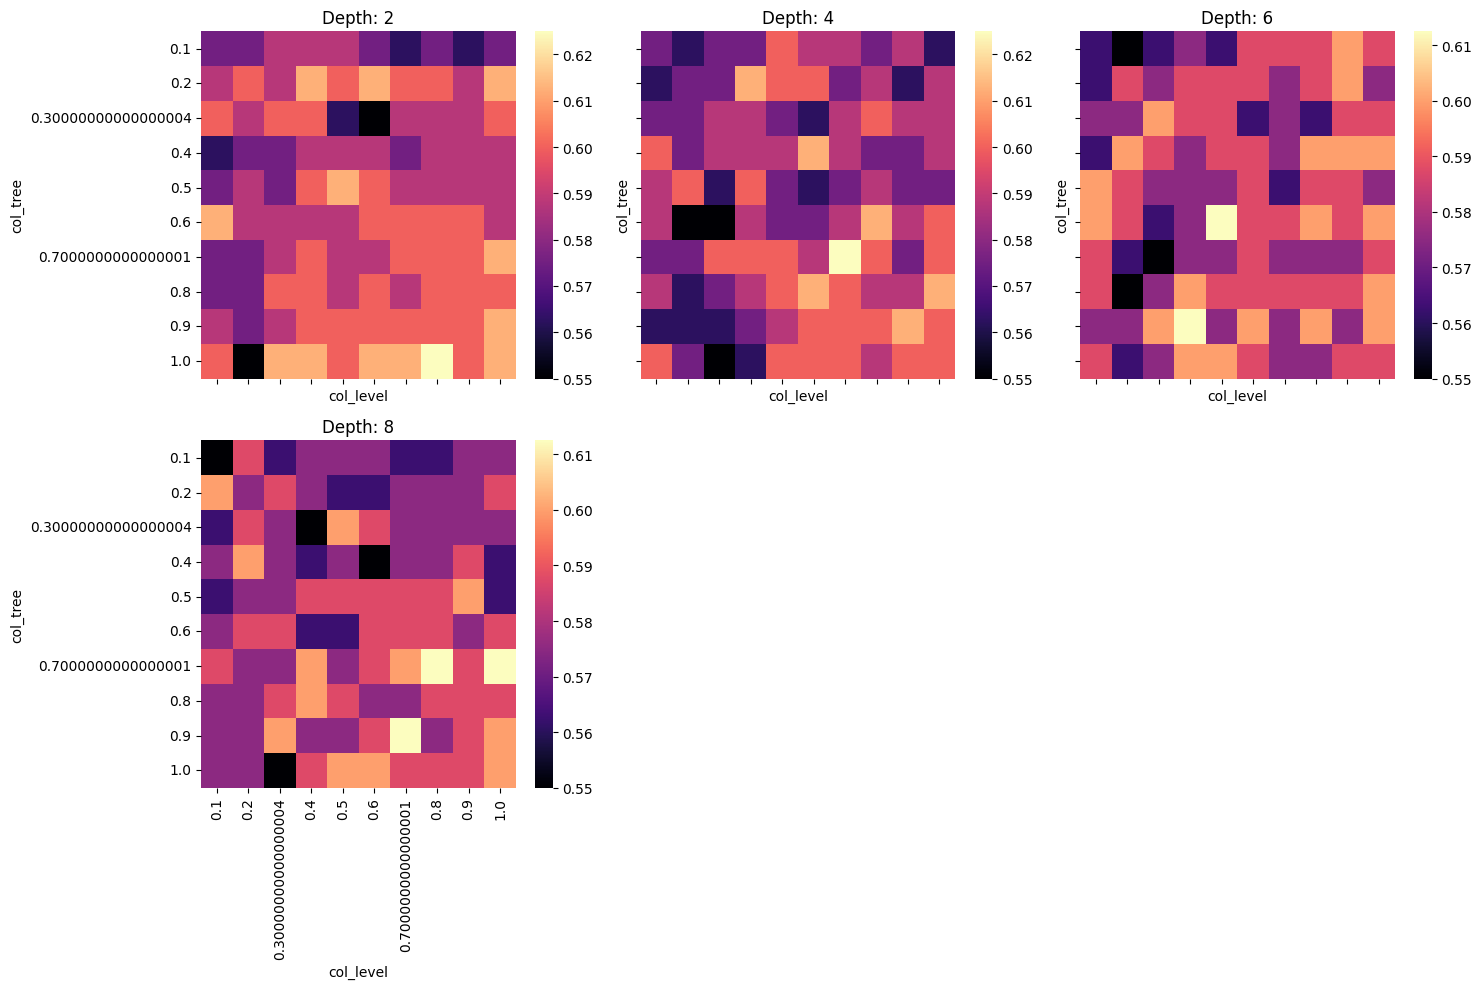

In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# 1. Convert your results list to a DataFrame
# (Assuming 'results' is a list of tuples like (depth, col_tree, col_level, score))
df = pd.DataFrame([(r["d"],r["colsamplebytree"],r["colsamplebylevel"],r["val_acc"]) for r in results], columns=['depth', 'col_tree', 'col_level', 'score'])
unique_depths = sorted(df['depth'].unique())
n_cols = 3
n_rows = math.ceil(len(unique_depths) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, d in enumerate(unique_depths):
    # Filter data for this specific depth
    subset = df[df['depth'] == d]
    
    # Pivot for the heatmap
    pivot_df = subset.pivot(index='col_tree', columns='col_level', values='score')
    
    sns.heatmap(pivot_df, ax=axes[i], annot=False, cmap='magma', fmt=".4f")
    axes[i].set_title(f"Depth: {d}")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [125]:
# import matplotlib.pyplot as plt
# results = xgb_gpu.evals_result()
# epochs = len(results['validation_0']['mlogloss'])
# x_axis = range(0, epochs)
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# # --- Plot 1: Log Loss ---
# ax[0].plot(x_axis, results['validation_0']['mlogloss'], label='Train')
# ax[0].plot(x_axis, results['validation_1']['mlogloss'], label='Val')
# ax[0].set_title('XGBoost Log Loss')
# ax[0].set_xlabel('Iterations')
# ax[0].set_ylabel('Log Loss')
# ax[0].legend()
# train_acc = [1 - x for x in results['validation_0']['merror']]
# val_acc = [1 - x for x in results['validation_1']['merror']]
# ax[1].plot(x_axis, train_acc, label='Train')
# ax[1].plot(x_axis, val_acc, label='Val')
# ax[1].set_title('XGBoost Classification Accuracy')
# ax[1].set_xlabel('Iterations')
# ax[1].set_ylabel('Accuracy')
# ax[1].legend()
# plt.tight_layout()
# plt.show()

# target_names = ['RPH', 'Blast', 'Rust', 'Aphid']
# print("\nTrain Results:")
# y_pred = xgb_gpu.predict(X_train)
# print(classification_report(y_train, y_pred, target_names=target_names))

# print("\nVal Results:")
# y_pred = xgb_gpu.predict(X_val)
# print(classification_report(y_val, y_pred, target_names=target_names))

# Deep Extractor

## Train Deep Extractor

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

def train_classification_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    learning_rate,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir='satlas_extracter_c9',
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0]),
    minus = 2
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Move model to device
    model = model.to(device)
    
    # Loss and optimizer
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    
    # Tracking
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    
    print(f"Training on {device}")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    
    for epoch in range(num_epochs):
        model.train()
        # ================== TRAINING ==================
        # Keep encoder in eval mode if frozen
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in pbar:
            images = batch['c9'].to(device)
            labels = batch['label'] - minus
            labels = labels.to(device)
            
            # Forward pass
            outputs = model.deep_classify(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # ================== VALIDATION ==================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch in pbar:
                images = batch['c9'].to(device)
                labels = batch['label'] - minus
                labels = labels.to(device)
                
                outputs = model.deep_classify(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * val_correct / val_total:.2f}%'
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, os.path.join(save_dir, 'best_classifier.pth'))
            print(f'  ✓ Saved best model with val_acc = {val_acc:.2f}%')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        
        print('-' * 60)
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', marker='o')
    ax2.plot(val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150)
    plt.show()
    
    print(f'\n🎉 Training complete!')
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

Total parameters: 96,743,076
Trainable parameters: 8,799,940
Frozen parameters: 87,943,136
Training on cuda
Total trainable parameters: 8,799,940


Epoch 1/30 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s, loss=0.9180, acc=37.50%]



Epoch 1/30:
  Train Loss: 1.3050 | Train Acc: 38.30%
  Val Loss:   1.2873 | Val Acc:   37.50%
  ✓ Saved best model with val_acc = 37.50%
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s, loss=1.0687, acc=42.50%] 



Epoch 2/30:
  Train Loss: 0.9963 | Train Acc: 54.47%
  Val Loss:   1.2012 | Val Acc:   42.50%
  ✓ Saved best model with val_acc = 42.50%
------------------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s, loss=0.2872, acc=53.75%]



Epoch 3/30:
  Train Loss: 0.8375 | Train Acc: 54.89%
  Val Loss:   0.8889 | Val Acc:   53.75%
  ✓ Saved best model with val_acc = 53.75%
------------------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.1552, acc=56.25%]



Epoch 4/30:
  Train Loss: 0.7553 | Train Acc: 62.98%
  Val Loss:   0.7778 | Val Acc:   56.25%
  ✓ Saved best model with val_acc = 56.25%
------------------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.5829, acc=60.00%]



Epoch 5/30:
  Train Loss: 0.7069 | Train Acc: 62.55%
  Val Loss:   0.7123 | Val Acc:   60.00%
  ✓ Saved best model with val_acc = 60.00%
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s, loss=0.2815, acc=62.50%]



Epoch 6/30:
  Train Loss: 0.6062 | Train Acc: 71.91%
  Val Loss:   0.6761 | Val Acc:   62.50%
  ✓ Saved best model with val_acc = 62.50%
------------------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.17it/s, loss=0.1521, acc=58.75%]



Epoch 7/30:
  Train Loss: 0.6568 | Train Acc: 68.51%
  Val Loss:   0.7454 | Val Acc:   58.75%
------------------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s, loss=0.1197, acc=63.75%]



Epoch 8/30:
  Train Loss: 0.5916 | Train Acc: 74.04%
  Val Loss:   0.8214 | Val Acc:   63.75%
  ✓ Saved best model with val_acc = 63.75%
------------------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.26it/s, loss=0.0418, acc=60.00%]



Epoch 9/30:
  Train Loss: 0.5431 | Train Acc: 74.04%
  Val Loss:   1.0954 | Val Acc:   60.00%
------------------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.36it/s, loss=0.2228, acc=65.00%]



Epoch 10/30:
  Train Loss: 0.5249 | Train Acc: 74.89%
  Val Loss:   0.7971 | Val Acc:   65.00%
  ✓ Saved best model with val_acc = 65.00%
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s, loss=0.4681, acc=68.75%]



Epoch 11/30:
  Train Loss: 0.5345 | Train Acc: 79.57%
  Val Loss:   0.6659 | Val Acc:   68.75%
  ✓ Saved best model with val_acc = 68.75%
------------------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s, loss=0.1531, acc=61.25%]



Epoch 12/30:
  Train Loss: 0.5182 | Train Acc: 78.72%
  Val Loss:   0.8702 | Val Acc:   61.25%
------------------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.41it/s, loss=0.4682, acc=67.50%]



Epoch 13/30:
  Train Loss: 0.4448 | Train Acc: 81.70%
  Val Loss:   0.6696 | Val Acc:   67.50%
------------------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.08it/s, loss=0.1042, acc=75.00%]



Epoch 14/30:
  Train Loss: 0.4143 | Train Acc: 80.00%
  Val Loss:   0.7020 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.53it/s, loss=0.3371, acc=67.50%]



Epoch 15/30:
  Train Loss: 0.4217 | Train Acc: 81.70%
  Val Loss:   0.6543 | Val Acc:   67.50%
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s, loss=0.1279, acc=72.50%]



Epoch 16/30:
  Train Loss: 0.2623 | Train Acc: 90.64%
  Val Loss:   0.8578 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.33it/s, loss=0.2201, acc=67.50%]



Epoch 17/30:
  Train Loss: 0.2469 | Train Acc: 91.06%
  Val Loss:   0.9497 | Val Acc:   67.50%
------------------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.13it/s, loss=0.2608, acc=65.00%]



Epoch 18/30:
  Train Loss: 0.3342 | Train Acc: 86.81%
  Val Loss:   0.8649 | Val Acc:   65.00%
------------------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s, loss=0.1172, acc=71.25%]



Epoch 19/30:
  Train Loss: 0.2970 | Train Acc: 87.23%
  Val Loss:   0.7800 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s, loss=0.1353, acc=68.75%]



Epoch 20/30:
  Train Loss: 0.2475 | Train Acc: 89.79%
  Val Loss:   0.9488 | Val Acc:   68.75%
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.40it/s, loss=0.1630, acc=73.75%]



Epoch 21/30:
  Train Loss: 0.1682 | Train Acc: 94.04%
  Val Loss:   0.7986 | Val Acc:   73.75%
------------------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.10it/s, loss=0.2475, acc=71.25%]



Epoch 22/30:
  Train Loss: 0.1114 | Train Acc: 97.45%
  Val Loss:   0.9175 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s, loss=0.1578, acc=73.75%]



Epoch 23/30:
  Train Loss: 0.1406 | Train Acc: 94.47%
  Val Loss:   0.9711 | Val Acc:   73.75%
------------------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, loss=0.3673, acc=72.50%]



Epoch 24/30:
  Train Loss: 0.1298 | Train Acc: 96.17%
  Val Loss:   0.8278 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 5/5 [00:01<00:00,  4.92it/s, loss=0.4347, acc=72.50%]



Epoch 25/30:
  Train Loss: 0.1001 | Train Acc: 98.30%
  Val Loss:   0.8840 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.18it/s, loss=0.1426, acc=72.50%]



Epoch 26/30:
  Train Loss: 0.0639 | Train Acc: 99.15%
  Val Loss:   1.1618 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s, loss=0.1543, acc=71.25%]



Epoch 27/30:
  Train Loss: 0.1505 | Train Acc: 96.60%
  Val Loss:   1.1634 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.25it/s, loss=0.1313, acc=76.25%]



Epoch 28/30:
  Train Loss: 0.1213 | Train Acc: 95.74%
  Val Loss:   1.0208 | Val Acc:   76.25%
  ✓ Saved best model with val_acc = 76.25%
------------------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s, loss=0.1564, acc=75.00%]



Epoch 29/30:
  Train Loss: 0.0660 | Train Acc: 98.72%
  Val Loss:   0.9907 | Val Acc:   75.00%
------------------------------------------------------------


Epoch 30/30 [Val]: 100%|██████████| 5/5 [00:00<00:00,  5.16it/s, loss=0.1337, acc=71.25%]



Epoch 30/30:
  Train Loss: 0.0609 | Train Acc: 98.30%
  Val Loss:   1.0542 | Val Acc:   71.25%
------------------------------------------------------------


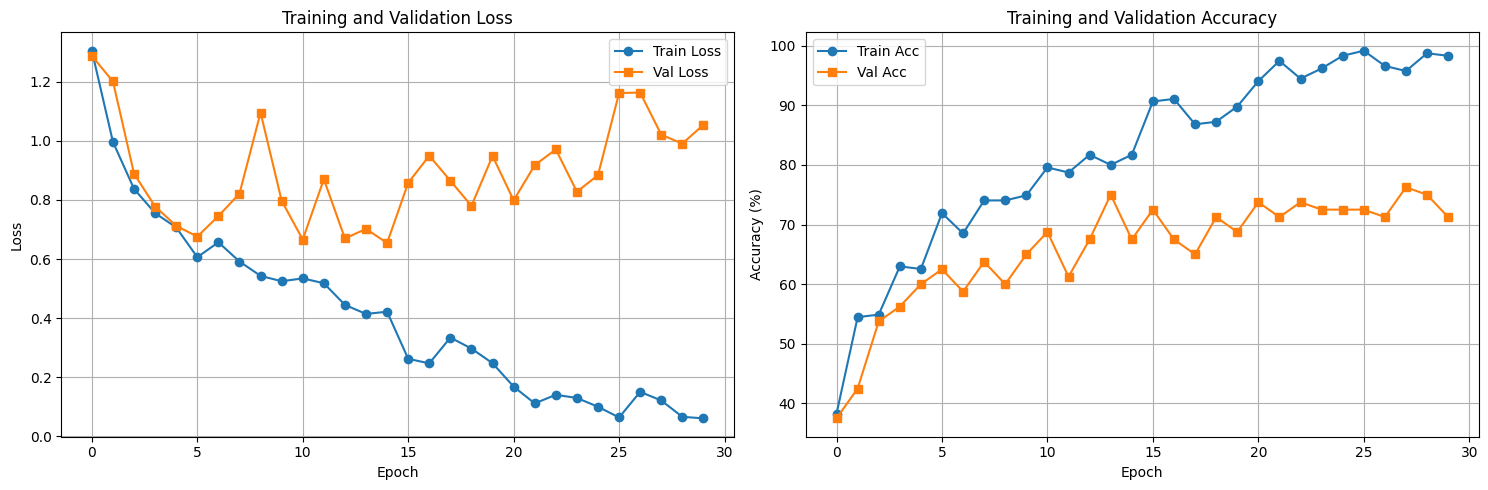


🎉 Training complete!
Best validation accuracy: 76.25%


In [15]:
model = FeatureExtractor()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

trained_model, history = train_classification_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=1e-4 * 4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    minus=0
)

## Grid Search

In [16]:
import torch
import numpy as np
from tqdm import tqdm

model = FeatureExtractor(reducer = "Deep")
model.load_state_dict(torch.load("satlas_extracter_c9/best_classifier_s2.pth")["model_state_dict"])

def extract_features_cuda(data_loader, model):
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    
    all_features = []
    all_labels = []
    
    print("Extracting features on GPU...")
    with torch.no_grad():
        for batch in tqdm(data_loader):
            # Move batch to GPU
            images = batch['c9'].to(device)
            
            # Forward pass: Output shape [batch, 1024]
            features = model(images)
            
            all_features.append(features.cpu())
            all_labels.append(batch['label'])
            
    # Concatenate all batches
    X = torch.cat(all_features, dim=0).numpy()
    y = torch.cat(all_labels, dim=0).numpy()
    
    return X, y

X_train, y_train = extract_features_cuda(train_loader, model)
X_val, y_val = extract_features_cuda(val_loader, model)

Extracting features on GPU...


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Extracting features on GPU...


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def tester(d,colsamplebytree,colsamplebylevel,lr = 0.05):
    xgb_gpu = XGBClassifier(
        tree_method='hist',
        device='cuda',
        n_estimators=200,
        learning_rate=lr,
        max_depth=d,
        objective='multi:softmax',
        num_class=4,

        # Pass a list of metrics to track both
        eval_metric=["mlogloss", "merror"], 

        subsample=1,
        colsample_bytree=colsamplebytree,
        colsample_bylevel=colsamplebylevel,
    )

    xgb_gpu.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    import matplotlib.pyplot as plt
    results = xgb_gpu.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)


    train_acc = [1 - x for x in results['validation_0']['merror']]
    val_acc = [1 - x for x in results['validation_1']['merror']]

    return {"num_estimators":np.argmax(np.array(val_acc)) + 1,
            "train_acc":np.array(train_acc)[np.argmax(np.array(val_acc))],
            "val_acc":np.max(np.array(val_acc)),
            "d":d,"colsamplebytree":colsamplebytree,
            "colsamplebylevel":colsamplebylevel,"lr":lr}


In [19]:
results = []

for d in tqdm([2,4,6,8],desc="depth"):
    for colsamplebytree in [(1/10) * i + (1/10) for i in range(10)]:
        for colsamplebylevel in [(1/10) * i + (1/10) for i in range(10)]:
            results.append(tester(d,colsamplebytree,colsamplebylevel))

depth: 100%|██████████| 4/4 [10:13<00:00, 153.36s/it]


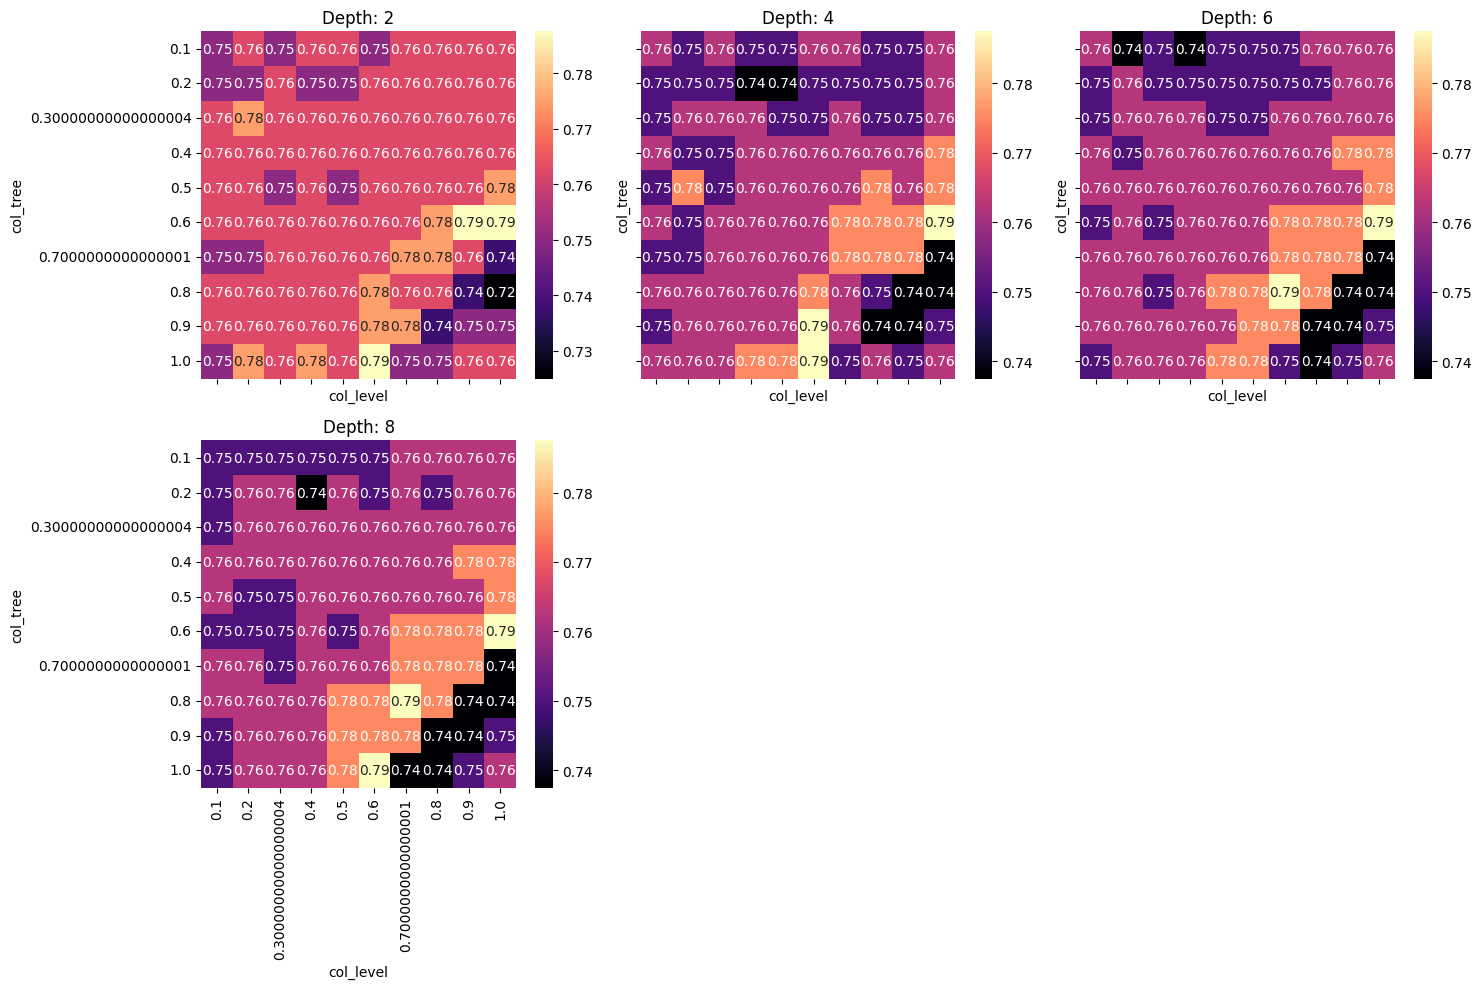

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = pd.DataFrame([(r["d"],r["colsamplebytree"],r["colsamplebylevel"],r["val_acc"]) for r in results], columns=['depth', 'col_tree', 'col_level', 'score'])
unique_depths = sorted(df['depth'].unique())
n_cols = 3
n_rows = math.ceil(len(unique_depths) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, d in enumerate(unique_depths):
    # Filter data for this specific depth
    subset = df[df['depth'] == d]
    
    # Pivot for the heatmap
    pivot_df = subset.pivot(index='col_tree', columns='col_level', values='score')
    
    sns.heatmap(pivot_df, ax=axes[i], annot=True, cmap='magma', fmt=".2f")
    axes[i].set_title(f"Depth: {d}")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [22]:
rs1 = []
for d in tqdm([2],desc="depth"):
    for colsamplebytree in [0.5 + i * (0.2/10) for i in range(11)]:
        for colsamplebylevel in [min(1,0.8 + i * (0.2/10)) for i in range(11)]:
            rs1.append(tester(d,colsamplebytree,colsamplebylevel))

depth: 100%|██████████| 1/1 [02:39<00:00, 159.56s/it]


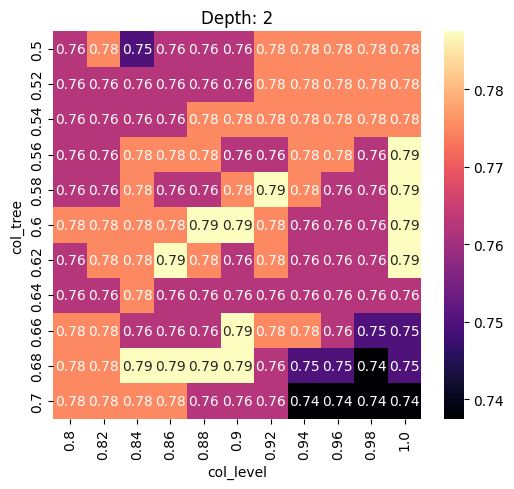

In [23]:
df = pd.DataFrame([(r["d"],round(r["colsamplebytree"],3),round(r["colsamplebylevel"],3),r["val_acc"]) for r in rs1], columns=['depth', 'col_tree', 'col_level', 'score'])
unique_depths = sorted(df['depth'].unique())
n_cols = 3
n_rows = math.ceil(len(unique_depths) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, d in enumerate(unique_depths):
    # Filter data for this specific depth
    subset = df[df['depth'] == d]
    
    # Pivot for the heatmap
    pivot_df = subset.pivot(index='col_tree', columns='col_level', values='score')
    
    sns.heatmap(pivot_df, ax=axes[i], annot=True, cmap='magma', fmt=".2f")
    axes[i].set_title(f"Depth: {d}")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [24]:
rs2 = []
for d in [6]:
    for colsamplebytree in tqdm([min(1,0.7 + i * (0.2/10)) for i in range(10)],desc="tree"):
        for colsamplebylevel in [min(1,0.6 + i * (0.2/10)) for i in range(10)]:
            rs2.append(tester(d,colsamplebytree,colsamplebylevel))

tree: 100%|██████████| 10/10 [03:08<00:00, 18.82s/it]


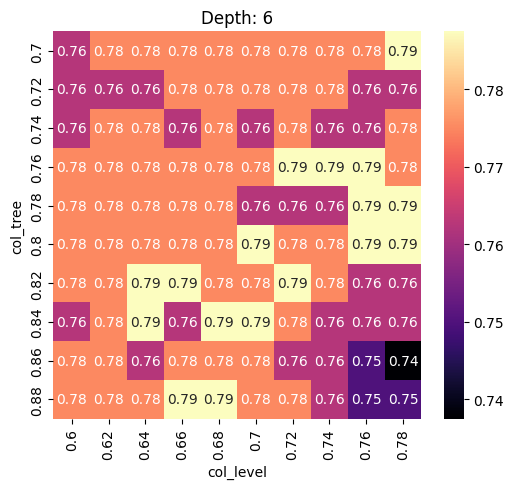

In [25]:
df = pd.DataFrame([(r["d"],round(r["colsamplebytree"],3),round(r["colsamplebylevel"],3),r["val_acc"]) for r in rs2], columns=['depth', 'col_tree', 'col_level', 'score'])
unique_depths = sorted(df['depth'].unique())
n_cols = 3
n_rows = math.ceil(len(unique_depths) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, d in enumerate(unique_depths):
    # Filter data for this specific depth
    subset = df[df['depth'] == d]
    
    # Pivot for the heatmap
    pivot_df = subset.pivot(index='col_tree', columns='col_level', values='score')
    
    sns.heatmap(pivot_df, ax=axes[i], annot=True, cmap='magma', fmt=".2f")
    axes[i].set_title(f"Depth: {d}")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Deep Grid checking

In [27]:
def save_test(d,colsamplebytree,colsamplebylevel,lr = 0.05):
    xgb_gpu = XGBClassifier(
        tree_method='hist',
        device='cuda',
        n_estimators=250,
        learning_rate=lr,
        max_depth=d,
        objective='multi:softmax',
        num_class=4,

        # Pass a list of metrics to track both
        eval_metric=["mlogloss", "merror"],
        early_stopping_rounds=100, 

        subsample=1,
        colsample_bytree=colsamplebytree,
        colsample_bylevel=colsamplebylevel,
    )

    xgb_gpu.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False,
        
    )

    n_best = xgb_gpu.best_iteration 
    xgb_gpu.save_model(f"./satlas_xgboostc9/model_at_n_{n_best}.json")

    results = xgb_gpu.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)


    train_acc = [1 - x for x in results['validation_0']['merror']]
    val_acc = [1 - x for x in results['validation_1']['merror']]

    return {"num_estimators":np.argmax(np.array(val_acc)) + 1,
            "train_acc":np.array(train_acc)[np.argmax(np.array(val_acc))],
            "val_acc":np.max(np.array(val_acc)),
            "d":d,"colsamplebytree":colsamplebytree,
            "colsamplebylevel":colsamplebylevel,"lr":lr
            }

In [28]:
save_test(6,0.78,0.76)

{'num_estimators': np.int64(102),
 'train_acc': np.float64(1.0),
 'val_acc': np.float64(0.7875),
 'd': 6,
 'colsamplebytree': 0.78,
 'colsamplebylevel': 0.76,
 'lr': 0.05}

In [29]:
save_test(6,0.78,0.78)

{'num_estimators': np.int64(79),
 'train_acc': np.float64(1.0),
 'val_acc': np.float64(0.7875),
 'd': 6,
 'colsamplebytree': 0.78,
 'colsamplebylevel': 0.78,
 'lr': 0.05}

In [30]:
save_test(6,0.8,0.78)

{'num_estimators': np.int64(86),
 'train_acc': np.float64(1.0),
 'val_acc': np.float64(0.7875),
 'd': 6,
 'colsamplebytree': 0.8,
 'colsamplebylevel': 0.78,
 'lr': 0.05}

In [31]:
save_test(6,0.8,0.76)

{'num_estimators': np.int64(100),
 'train_acc': np.float64(1.0),
 'val_acc': np.float64(0.7875),
 'd': 6,
 'colsamplebytree': 0.8,
 'colsamplebylevel': 0.76,
 'lr': 0.05}

In [32]:
from xgboost import XGBClassifier

loaded_model = XGBClassifier()
loaded_model.load_model("./satlas_xgboostc9/model_at_n_78.json")
preds1 = loaded_model.predict(X_val,iteration_range=(0, 78))

loaded_model = XGBClassifier()
loaded_model.load_model("./satlas_xgboostc9/model_at_n_85.json")
preds2 = loaded_model.predict(X_val,iteration_range=(0, 85))

loaded_model = XGBClassifier()
loaded_model.load_model("./satlas_xgboostc9/model_at_n_99.json")
preds3 = loaded_model.predict(X_val,iteration_range=(0, 99))

loaded_model = XGBClassifier()
loaded_model.load_model("./satlas_xgboostc9/model_at_n_101.json")
preds4 = loaded_model.predict(X_val,iteration_range=(0, 101))

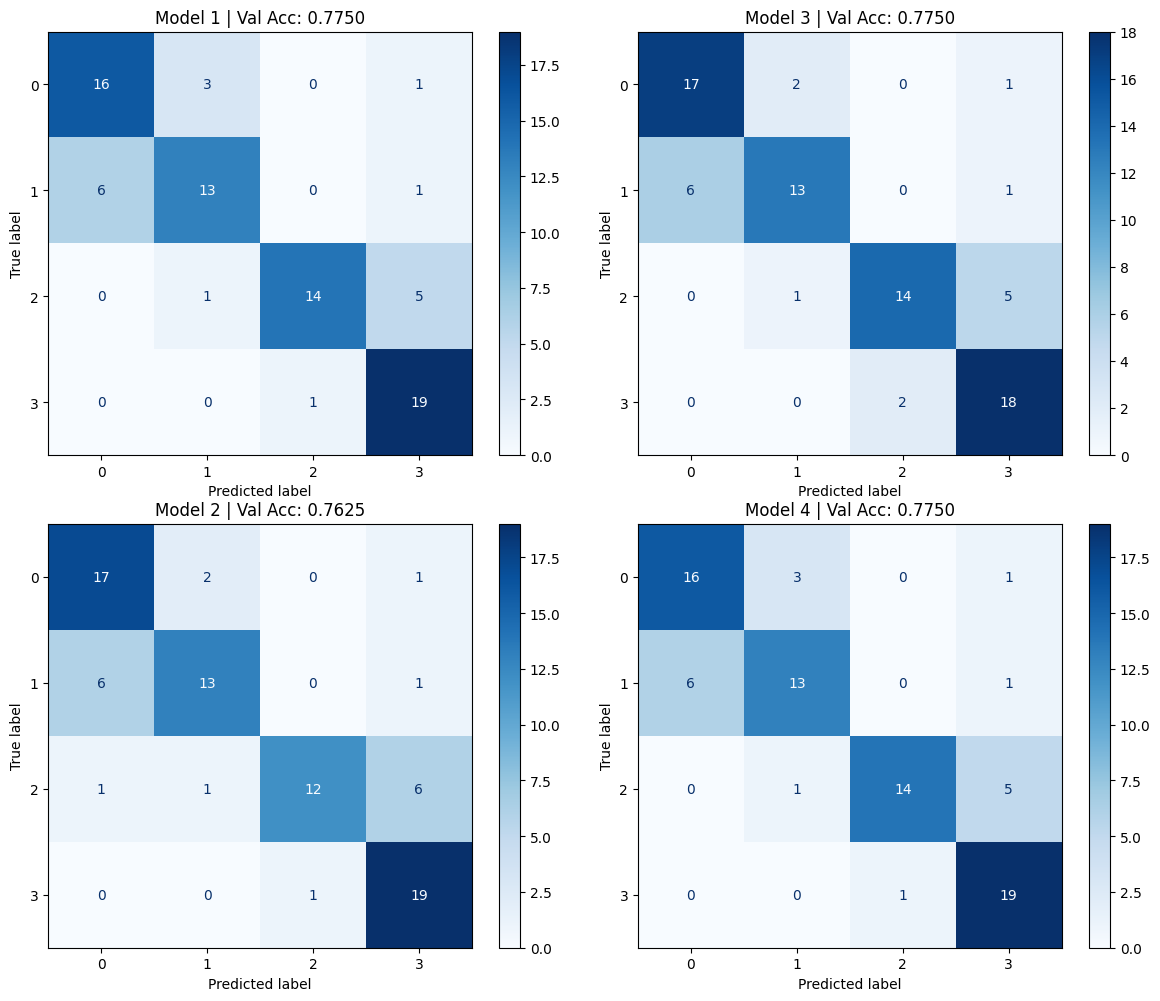

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate matrices
cm_1 = confusion_matrix(y_val, preds1)
cm_2 = confusion_matrix(y_val, preds2)
cm_3 = confusion_matrix(y_val, preds3)
cm_4 = confusion_matrix(y_val, preds4)

from sklearn.metrics import accuracy_score

# Calculate accuracies
acc1 = accuracy_score(y_val, preds1)
acc2 = accuracy_score(y_val, preds2)
acc3 = accuracy_score(y_val, preds3)
acc4 = accuracy_score(y_val, preds4)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Matrix 1 - Top Left
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_1)
disp1.plot(ax=ax[0, 0], cmap='Blues', values_format='d')
ax[0, 0].set_title(f'Model 1 | Val Acc: {acc1:.4f}')

# Matrix 2 - Bottom Left
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp2.plot(ax=ax[1, 0], cmap='Blues', values_format='d')
ax[1, 0].set_title(f'Model 2 | Val Acc: {acc2:.4f}')

# Matrix 3 - Top Right
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm_3)
disp3.plot(ax=ax[0, 1], cmap='Blues', values_format='d')
ax[0, 1].set_title(f'Model 3 | Val Acc: {acc3:.4f}')

# Matrix 4 - Bottom Right
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm_4)
disp4.plot(ax=ax[1, 1], cmap='Blues', values_format='d')
ax[1, 1].set_title(f'Model 4 | Val Acc: {acc4:.4f}')

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

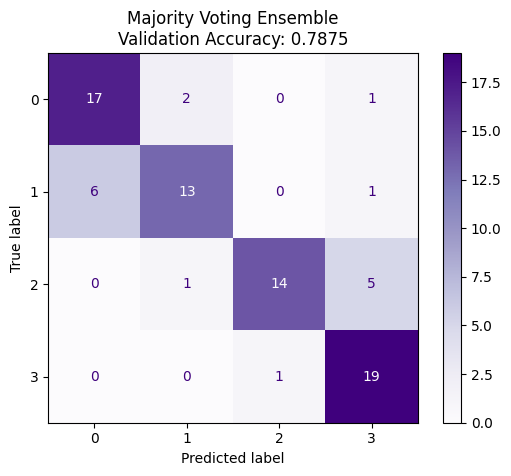

In [34]:
import numpy as np
from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# 1. Stack the 4 sets of predictions into a (4, N) array
# Each row is a set of predictions, each column is an observation
all_preds = np.array([preds1, preds2, preds3, preds4])

# 2. Compute the mode along the columns (axis=0)
# This finds the most frequent prediction for each sample
voting_result = stats.mode(all_preds, axis=0, keepdims=True)
final_preds = voting_result.mode[0]

# 3. Calculate Accuracy and Confusion Matrix
voting_acc = accuracy_score(y_val, final_preds)
cm_voting = confusion_matrix(y_val, final_preds)

# 4. Display the results
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_voting)
disp.plot(cmap='Purples', values_format='d')

plt.title(f'Majority Voting Ensemble\nValidation Accuracy: {voting_acc:.4f}')
plt.show()

## Using best XGboost for submission

In [3]:
import sys
import torch
sys.path.append('../')
from eval import EvalDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
data_eval = EvalDataset("..\\ICPR02\\kaggle",target_size=(256, 256))

Found 40 samples with all 12 bands


In [12]:
import torch
import numpy as np
from tqdm import tqdm

def get_pred(num):
    xgb = XGBClassifier()
    xgb.load_model(f"./satlas_xgboostc9/model_at_n_{num}.json")

    model = FeatureExtractor(reducer = "Deep").to(device)
    model.load_state_dict(torch.load("satlas_extracter_c9/best_classifier_s2.pth")["model_state_dict"])

    with torch.no_grad():
        features = []
        for i in tqdm(range(len(data_eval))):
            input = (torch.from_numpy(data_eval.__getitem__(i)['c9']).to(device)).unsqueeze(0)
            features.append(model(input).cpu().numpy()[0])
        
        features_np = np.vstack(features)
        print(features_np.shape)
        pred = xgb.predict(features_np,iteration_range=(0, 78))

    pred = list(pred)
    pred = [int(p) for p in pred]
    return pred

preds = []
for num in [78,85,99,101]:
    preds.append(get_pred(num))

100%|██████████| 40/40 [00:03<00:00, 12.48it/s]


(40, 1024)


100%|██████████| 40/40 [00:03<00:00, 12.84it/s]


(40, 1024)


100%|██████████| 40/40 [00:03<00:00, 11.95it/s]


(40, 1024)


100%|██████████| 40/40 [00:17<00:00,  2.28it/s]

(40, 1024)


In [ ]:
import numpy as np
from scipy import stats

preds_np = np.array(preds)
voting_result = stats.mode(preds_np, axis=0, keepdims=True)
final_preds_list = voting_result.mode[0].astype(int).tolist()

print(f"Total predictions: {len(final_preds_list)}")
print(f"Sample of first 10 predictions: {final_preds_list[:10]}")
print(f"Unique classes found in ensemble: {np.unique(final_preds_list)}")

Total predictions: 40
Sample of first 10 predictions: [3, 0, 0, 3, 3, 3, 3, 1, 3, 0]
Unique classes found in ensemble: [0 1 2 3]


In [15]:
data_eval.write_csv(final_preds_list,".\\Xgboost_subs")

Writing submission to .\Xgboost_subs\submission.csv...
Successfully wrote 40 predictions.
